# NVIDIA DALI

This tutorial showcases how Squirrel and NVIDIA DALI, a GPU-accelerated data loading and data augmentation library, can work together. The below code was tested on the following system:

- NVIDIA-SMI 460.32.03
- CUDA Version: 11.2
- GPU: NVIDIA Tesla T4
- Python Version: 3.8.16

Required dependencies can be installed with

In [ ]:
%%capture
!pip install squirrel-core squirrel-datasets-core[torchvision] squirrel-datasets-core[huggingface] seaborn pandas ipywidgets
!pip install --extra-index-url https://developer.download.nvidia.com/compute/redist --upgrade nvidia-dali-cuda110

## Preparing a Dataset

First, let's prepare a dataset with which we can run this tutorial. The code downloads the Imagenette dataset from Huggingface and pre-processes it into a Squirrel Messagepack dataset of images of shape `(3, 300, 300)`. 

In [ ]:
%%capture
from create_sq_ds_from_hf import create_sq_ds_from_hf 
from create_imagenette import to_np_dict_imagenette

create_sq_ds_from_hf(
    "frgfm/imagenette",
    to_np_dict=to_np_dict_imagenette,
    shard_size=1000,
    subset="320px",
    hf_split="train",
)

## Integrating Squirrel with DALI

Let's understand how we can integrate Squirrel into DALI. DALI is based on a concept called `nvidia.dali.Pipeline` that defines the data processing graph. Let's see what's happening in the below function `get_dali_it`. 
- Within the pipeline definition, Squirrel interfaces with DALI as an `external_source`, an API by DALI that reads from a given iterable. 
- As an example, we define two run-time augmentations (center-crop and rotation) that DALI is instructed to execute directly on the GPU.
- The pipeline is then built, and a pipeline instance is handed to the `DALIGenericIterator` that returns PyTorch tensors. You can think of the `DALIGenericIterator` as analogous to the `torch.utils.data.DataLoader`.

In [3]:
import typing as t
from collections import defaultdict
from time import time

import matplotlib.pyplot as plt
import numpy as np
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import pandas as pd
import seaborn as sns
import torch
import torchvision.transforms.functional as F
from nvidia.dali import pipeline_def
from nvidia.dali.pipeline import DataNode
from nvidia.dali.plugin.pytorch import DALIGenericIterator
from squirrel.driver.msgpack import MessagepackDriver
from squirrel.iterstream import Composable

# properties of the squirrel dataset
URL = "frgfm/imagenette/train"
DS_LEN = 9469
IMG_KEY = "image"
LABEL_KEY = "label"

# augmentation config
AUG_SIZE = 200
AUG_ROT = 30
BATCH_SIZE = 512


def get_dali_it(
    it: Composable,
    already_batched: bool,
    batch_size: int = BATCH_SIZE,
    center_crop_size: int = AUG_SIZE,
    rot: float = AUG_ROT,
    num_threads: int = 4,
    device: str = "gpu",
    device_id: int = 0,
    img_key: str = IMG_KEY,  # image key of squirrel iterator
    label_key: str = LABEL_KEY,  # label key of squirrel iterator
) -> DALIGenericIterator:
    @pipeline_def
    def pipeline(it: Composable) -> t.Tuple[DataNode]:
        """DALI pipeline defining the data processing graph for a Squirrel Composable that yields batched (image, label) tuples.

        Args:
            it (Composable): Squirrel composable.

        Returns:
            t.Tuple[DataNode]: The outputs of the operators.
        """
        imgs, labels = fn.external_source(
            source=it,
            num_outputs=2,
            device=device,
            dtype=types.FLOAT,  # means float32
            batch=already_batched,
        )
        imgs = fn.crop(
            imgs,
            crop=[center_crop_size, center_crop_size],
            crop_pos_x=0.5,
            crop_pos_y=0.5,
            device=device,
        )
        imgs = fn.rotate(imgs, angle=rot, device=device, fill_value=0, interp_type=types.INTERP_LINEAR, keep_size=True)

        return imgs, labels

    pipe = pipeline(it=it, batch_size=batch_size, num_threads=num_threads, device_id=device_id)
    pipe.build()

    return DALIGenericIterator([pipe], [img_key, label_key])

Now that we have a function that creates a DALI data loader from a Squirrel `Composable` let's create our Squirrel iterable. Let's have a look at the first four images of the dataset.

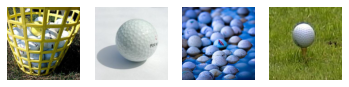

In [11]:
def plot_imgs(imgs):
    num_imgs = len(imgs)
    f, ax = plt.subplots(1, num_imgs)
    for i in range(num_imgs):
        img = imgs[i]
        if type(img) == torch.Tensor:
            img = img.cpu().numpy()
        ax[i].imshow(img)
        ax[i].set_axis_off()


num_viz_imgs = 4
access_img = lambda x: x[IMG_KEY]

sq_it = MessagepackDriver(URL).get_iter()
imgs = sq_it.take(num_viz_imgs).map(access_img).collect()
plot_imgs(imgs)

Hooray, we are seeing a bunch of images. Now let's feed the data into the DALI pipeline and obtain the augmented images.

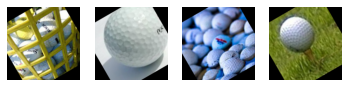

In [12]:
def pre_proc_for_dali(item: t.Dict[str, np.ndarray]) -> t.List[np.ndarray]:
    """Converts a dict to a list of numpy arrays. DALI only accepts list."""
    return [np.array(v, dtype=np.float32) for v in item.values()]


sq_it = MessagepackDriver(URL).get_iter().map(pre_proc_for_dali)
dali_it = get_dali_it(it=sq_it, batch_size=num_viz_imgs, already_batched=False)

pipe_out = next(iter(dali_it))
imgs = pipe_out[0][IMG_KEY]  # dali_it returns a list of outputs (one for each pipeline) and we only have one pipeline, hence access first pipeline
plot_imgs(imgs[:num_viz_imgs])

We can see how DALI augments the images. If you want to feed your training loop with the DALI iterable, you could do so with the following code: 

```python
model = MyModel(...)
for pipes_out in dali_it:
    item = pipes_out[0]  # unpack your pipelines
    imgs, labels = item["image"], item["label"] 
    logits = model(imgs)
    ...
```

Let's briefly build a typical pipeline based on Torchvision transforms, which we will use later for performance comparisons. The Squirrel pipeline that runs Torchvision transforms returns the same visual output as the DALI pipeline - sanity check complete!

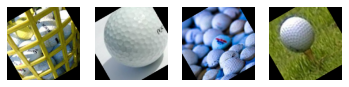

In [13]:
def pre_proc_torchvision(item: t.Dict[str, np.ndarray], device: torch.device = "cpu") -> t.Dict[str, torch.Tensor]:
    img = item[IMG_KEY]
    img = torch.from_numpy(img).to(device)
    img = img.permute((2, 0, 1))  # convert data from HWC to CHW for transforms
    img = F.center_crop(img, AUG_SIZE)
    img = F.rotate(img, AUG_ROT)

    item[IMG_KEY] = img.permute((1, 2, 0))  # convert back to HWC
    item[LABEL_KEY] = torch.from_numpy(item[LABEL_KEY]).to(device)
    return item


th_it = MessagepackDriver(URL).get_iter().map(pre_proc_torchvision)
imgs = th_it.take(num_viz_imgs).map(access_img).collect()
plot_imgs(imgs)

## Performance Guidelines DALI

Now that we know how to create a Squirrel-based DALI data loader let's see how to utilize it best. The below code builds some utility functions that measure the loading speed of an iterable and plot results.

In [6]:
def benchmark_it(
    it: t.Callable[[], t.Iterable],
    n_exp: int = 5,
    batch_size: int = BATCH_SIZE,
    ds_len: int = DS_LEN,
    img_h: int = AUG_SIZE,
    img_w: int = AUG_SIZE,
    img_key: str = IMG_KEY,
    device: torch.device = "cuda:0",
) -> float:
    """Benchmarks loading speed of an iterable. Checks data format and device."""
    print(f"Conducting {n_exp} experiments ...")

    def _run_experiment(it: t.Iterable) -> float:
        t = time()
        num_samples = 0
        expect_num_batches = ds_len // batch_size

        for idx, item in enumerate(it):
            # for DALI pipelines, we get a list of pipeline outputs
            if type(item) == list:
                assert len(item) == 1  # we only have one pipeline, can access its output
                item = item[0]

            imgs = item[img_key]
            num_samples += imgs.shape[0]

            # check whether data in correct format and on device
            assert type(item) == dict
            assert type(imgs) == torch.Tensor
            assert imgs.shape == torch.Size([batch_size, img_h, img_w, 3]), f"{imgs.shape}"
            assert imgs.device == torch.device(device)

        actual_num_batches = idx + 1
        assert expect_num_batches == actual_num_batches, f"{expect_num_batches} != {actual_num_batches}"
        samples_per_sec = num_samples / (time() - t)

        return samples_per_sec

    speeds = [_run_experiment(it()) for _ in range(n_exp)]
    print(f"Samples per second: {speeds}")
    
    return speeds


def plot_results(
    results: t.Dict[str, float], title: str, x_label: str = "Framework", y_label: str = "Samples per Second"
):
    sns.set_theme(style="darkgrid")
    sns.set_palette(["#9E36FF", "#11D8C1", "#CE3D4A", "#1D0693", "#007D85"])  # merantix momentum colors
    ax = sns.barplot(data=pd.DataFrame(data=results))
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

### Batch in Squirrel or DALI?

Both DALI and Squirrel come with batching functionality. In which part of your pipeline should you batch? The below results show that batching in DALI is slightly faster. By batching in DALI, users also avoid having to write a custom (and potentially slow) collation function.

Conducting 5 experiments ...
Samples per second: [142.66392683900443, 135.87426791622548, 136.92802813919857, 137.27695543837837, 132.7664031280724]
Conducting 5 experiments ...
Samples per second: [133.4174000995052, 126.06113362880966, 129.01778274101076, 127.36907975615293, 124.90424674473644]


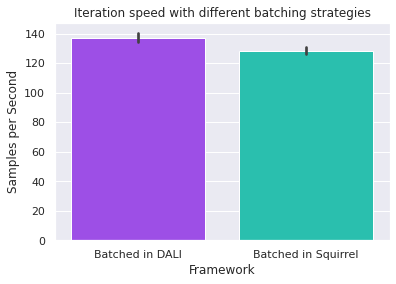

In [13]:
# batch in DALI (uses sq_it from above)
dali_it = lambda: get_dali_it(it=sq_it, already_batched=False)
result_batch_in_dali = benchmark_it(dali_it)

# batch in Squirrel
def collation_fn(items: t.List[t.Dict[str, np.ndarray]]) -> t.List[np.ndarray]:
    batch = defaultdict(list)
    for item in items:
        for k, v in item.items():
            batch[k].append(v)
    return [np.array(v, dtype=np.float32) for v in batch.values()]


it_batched = MessagepackDriver(URL).get_iter().batched(BATCH_SIZE, collation_fn)
dali_it_batch_in_squirrel = lambda: get_dali_it(it=it_batched, already_batched=True)
result_batch_in_squirrel = benchmark_it(dali_it_batch_in_squirrel)

results = {"Batched in DALI": result_batch_in_dali, "Batched in Squirrel": result_batch_in_squirrel}
plot_results(results, "Iteration speed with different batching strategies")

### Return Cupy or Numpy Arrays?

DALI can read `numpy` arrays (on CPU) or `cupy` arrays (on GPU) from external sources. Which one is faster? The below results suggest that directly creating `cupy` arrays is a bit faster. Be aware of the memory footprint of directly creating arrays on the GPU.

In [8]:
%%capture
!pip install cupy-cuda11x

Conducting 5 experiments ...
Samples per second: [142.8188631137334, 142.91088551686136, 140.967459451863, 141.38187142523887, 142.3319960197551]


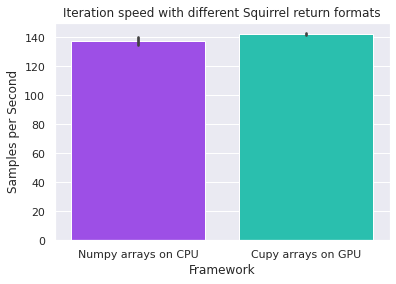

In [17]:
import cupy as cp


def pre_proc_for_dali_cupy(item: t.Dict[str, cp.ndarray]) -> t.List[cp.ndarray]:
    """Converts a dict to a list of cupy arrays. DALI only accepts lists."""
    return [cp.array(v, dtype=cp.float32) for v in item.values()]


sq_it_cp = MessagepackDriver(URL).get_iter().map(pre_proc_for_dali_cupy)
dali_it_cp = lambda: get_dali_it(it=sq_it_cp, already_batched=False)
result_cp = benchmark_it(dali_it_cp)

results = {"Numpy arrays on CPU": result_batch_in_dali, "Cupy arrays on GPU": result_cp}
plot_results(results, "Iteration speed with different Squirrel return formats")

### Role of Number of Threads?

DALI pipelines can read external sources in a multi-threaded manner. What's the impact of the number of threads on the data loading throughput? Of course, this will differ for each dataset, machine, and loading setting. However, it's interesting to get a rough feel for the importance of this parameter. The results show only minor differences in this case, which indicates that the number of threads does not bottleneck the code.

Conducting 5 experiments ...
Samples per second: [146.2558350307886, 153.49054923835627, 153.99429080194957, 153.83547090120513, 154.56215522390596]
Conducting 5 experiments ...
Samples per second: [154.8344308396196, 154.35314446703015, 154.6798785163675, 152.40237937823622, 154.54069059181336]
Conducting 5 experiments ...
Samples per second: [154.3716736065559, 152.71661504235544, 153.8712600654633, 154.51485393720156, 152.8186483199712]
Conducting 5 experiments ...
Samples per second: [154.5332575912717, 154.51187448086432, 151.98396958941765, 154.6547050220404, 153.6805946343663]
Conducting 5 experiments ...
Samples per second: [151.84645979863532, 154.27101556598618, 154.51604785193177, 152.24865037958293, 154.23921773071734]
Conducting 5 experiments ...
Samples per second: [154.5531833008394, 152.72407946534383, 154.1892347954226, 154.71717760354, 152.79373752063805]
Conducting 5 experiments ...
Samples per second: [154.80233029200272, 154.49577418765668, 152.5959274195581, 154.2

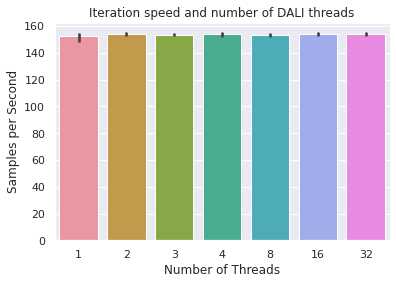

In [10]:
num_threads = [1, 2, 3, 4, 8, 16, 32]
results = {}

for thr in num_threads:
    dali_it_cp = lambda: get_dali_it(it=sq_it_cp, num_threads=thr, already_batched=False)
    results[thr] = benchmark_it(dali_it_cp)

plot_results(results, "Iteration speed and number of DALI threads", x_label="Number of Threads")

## Benchmarks 

Lastly, let's investigate the performance benefit of using DALI instead of Torchvision. Torchvision can do image augmentation both on the CPU and GPU. The plots below show that DALI outperforms both Torchvision frameworks on this simple image augmentation task. We assume the difference is even more significant for more complex image augmentations.

Conducting 5 experiments ...
Samples per second: [107.93314326438042, 109.1074383127871, 108.02509450856462, 101.88372640135306, 98.974527403659]
Conducting 5 experiments ...
Samples per second: [106.90104520371735, 112.1274796145367, 109.03321575887472, 113.43106441237688, 114.89872670642427]


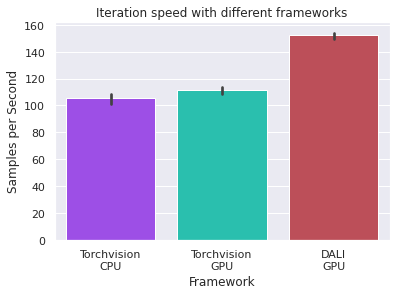

In [14]:
from torch.utils.data import default_collate

to_cuda = lambda x: {k: v.to("cuda:0") for k, v in x.items()}
th_it_cpu = (
    lambda: MessagepackDriver(URL)
    .get_iter()
    .map(pre_proc_torchvision)
    .batched(BATCH_SIZE, default_collate)
    .map(to_cuda)
)
result_th_cpu = benchmark_it(th_it_cpu)

pre_proc_cuda = lambda x: pre_proc_torchvision(x, "cuda:0")
th_it_gpu = lambda: MessagepackDriver(URL).get_iter().map(pre_proc_cuda).batched(BATCH_SIZE, default_collate)
result_th_gpu = benchmark_it(th_it_gpu)

results = {
    "Torchvision\nCPU": result_th_cpu,
    "Torchvision\nGPU": result_th_gpu,
    "DALI\nGPU": results[1],
}
plot_results(results, "Iteration speed with different frameworks")